In [123]:
import strym as s
from strym import strymmap
from strym import strymread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
#from datetime import datetime as dt
import urllib.request
import os
import cantools
import warnings
warnings.filterwarnings("ignore")

In [124]:
def conv_time(unix_timestamp):
    unix_format = int(unix_timestamp)
    dt_format = datetime.datetime.fromtimestamp(unix_format, datetime.timezone.utc)
    dt_str = dt_format.strftime("%Y-%m-%d %H:%M:%S (%Z)")
    return dt_str

**Load the Toyota CAN data from file 2020-07-08-20-22-14_Toyota_CAN_Messages.csv.**

In [125]:
data_path = 'data/miniTest1/'
current_can_file_name = '2020-07-08-20-22-14_Toyota_CAN_Messages.csv'
toyota_can_file = data_path + current_can_file_name
toyota_can = pd.read_csv(toyota_can_file)
toyota_can.head(1)

,Time,Bus,MessageID,Message,MessageLength
0,1.594265e+09,0,295,0010000806303cba,8


## How Long

In [126]:
can_start_dt = toyota_can.Time.min()
can_end_dt = toyota_can.Time.max()
duration = can_end_dt - can_start_dt
duration

938.8985028266907

In [127]:
m, s = divmod(duration, 60)
h, m = divmod(m, 60)
print("The start datetime of this file is: ", conv_time(can_start_dt))
print("The end datetime of this file is: ", conv_time(can_end_dt))
print("The total duration is: %d:%02d:%02d" % (h, m, s))

The start datetime of this file is:  2020-07-09 03:22:14 (UTC)
The end datetime of this file is:  2020-07-09 03:37:53 (UTC)
The total duration is: 0:15:38


## How Fast

In [128]:
dbcfile = 'data/dbc/toyota_rav4_2019.dbc'
csvdata = toyota_can_file

r =strymread(csvfile=csvdata, dbcfile = dbcfile, createdb = True, verbose=False)
ts_speed = r.speed()
ts_speed.reset_index(inplace=True)
ts_speed.head(1)

UNIQUE constraint failed: RAW_CAN.Clock, RAW_CAN.Bus, RAW_CAN.MessageID, RAW_CAN.Message


,Clock,Time,Message
0,2020-07-09 03:22:14.401134848,1.594265e+09,45.16


In [129]:
avg_speed = ts_speed.Message.sum() / ts_speed.shape[0]
print("The average speed of the vehicle is:", round(avg_speed,2), "km/h.")

The average speed of the vehicle is: 62.49 km/h.


In [130]:
max_speed = ts_speed.Message.max()
print("The maximum speed of this vehicle is:", round(max_speed,2), "km/h.")

The maximum speed of this vehicle is: 111.21 km/h.


## How Far

In [131]:
duration = (toyota_can.Time.max() - toyota_can.Time.min()) / 3600
total_distance = duration * avg_speed
print("The total distance the vehicle travels in the direction of travel is:", round(total_distance,2), "km.")

The total distance the vehicle travels in the direction of travel is: 16.3 km.


## More Analystic

In [133]:
import cantools
import strym as s
db = cantools.database.Database()
with open(dbcfile,'r') as fin:    
    db = cantools.database.load(fin)
drive = pd.read_csv(csvdata)
cruise_state = s.convertData('PCM_CRUISE','CRUISE_ACTIVE',drive,db)

In [134]:
#calculate odometer from speed messgae
cruise_state.reset_index(drop=True,inplace=True)
cruise_state_c = cruise_state.copy()
cruise_state_c.index += 1
cruise_state_c = cruise_state_c[['Time','Message']]
cruise_state_c.columns = ['Time_prev','Message_prev']
cruise_state_concat = pd.concat([cruise_state,cruise_state_c],axis=1)
cruise_state_concat.dropna(inplace=True)
cruise_state_concat.head(1)

,Time,Message,Bus,Time_prev,Message_prev
1,1.594265e+09,0.0,0.0,1.594265e+09,0.0


In [135]:
cruise_state_concat['time_gap'] = cruise_state_concat.Time - cruise_state_concat.Time_prev
cruise_state_concat['label'] = -1
cruise_state_concat.loc[(cruise_state_concat.Message==0)&(cruise_state_concat.Message_prev==0), "label"] = 0
cruise_state_concat.loc[(cruise_state_concat.Message==1)&(cruise_state_concat.Message_prev==1), "label"] = 1
cruise_state_sum = cruise_state_concat.groupby("label").agg({'time_gap': ['sum']})
cruise_state_sum.reset_index(drop=False,inplace=True)

In [136]:
cruise_state_sum.columns = ['CruiseState','duration']
cruise_on_duration = cruise_state_sum[cruise_state_sum.CruiseState==1].duration[2]
cruise_off_duration = cruise_state_sum[cruise_state_sum.CruiseState==0].duration[1]
cruise_on_percentage = cruise_on_duration / (cruise_on_duration+cruise_off_duration)

# Cruise ON
m, s = divmod(cruise_on_duration, 60)
h, m = divmod(m, 60)
print("The total cruise control ON duration is: %d:%02d:%02d" % (h, m, s))

# Cruise OFF
m, s = divmod(cruise_off_duration, 60)
h, m = divmod(m, 60)
print("The total cruise control ON duration is: %d:%02d:%02d" % (h, m, s))

# Cruise ON percentage
print("The cruise control ON percentage is:", round(cruise_on_percentage*100, 2), "%")

The total cruise control ON duration is: 0:08:12
The total cruise control ON duration is: 0:07:26
The cruise control ON percentage is: 52.45 %


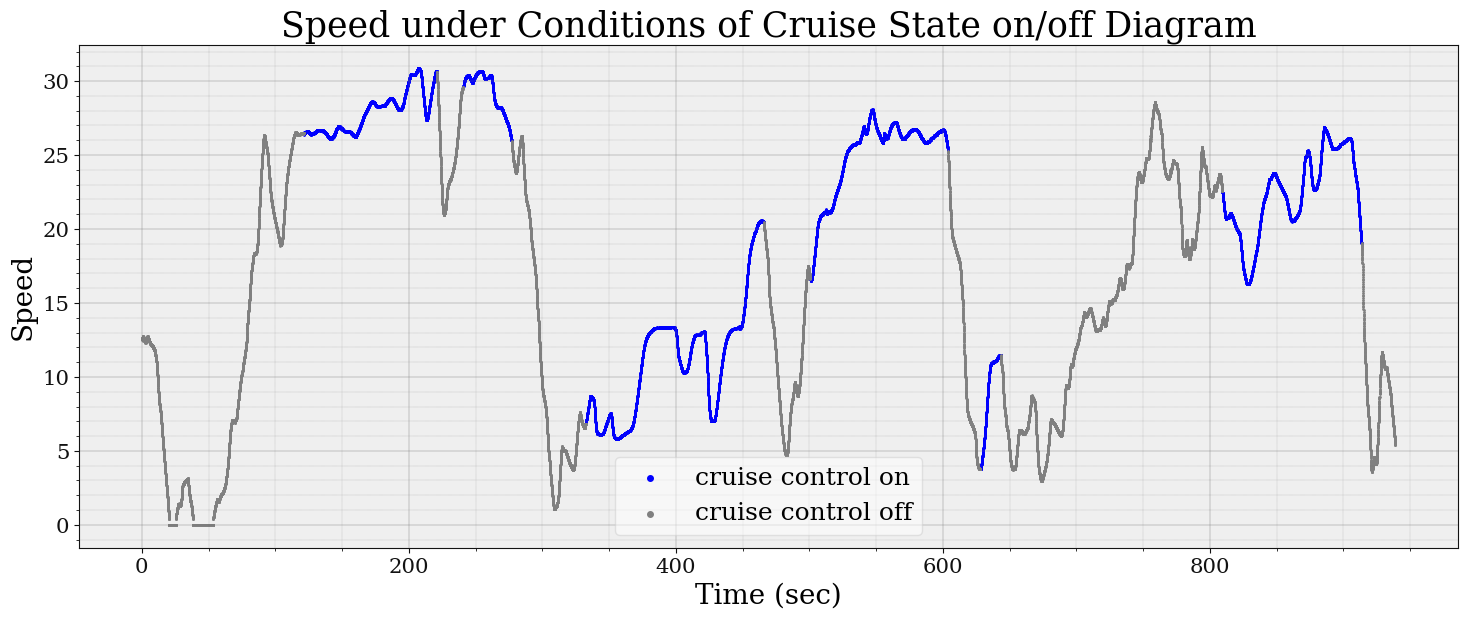

In [137]:
# Adaptive Cruise Control State & Speed
cruise_state.columns = ['Time','CruiseState','Bus']
cruise_speed_merge_data = pd.merge_asof(ts_speed[['Clock','Time','Message']],cruise_state[['Time','CruiseState']],on='Time',allow_exact_matches=False,direction='backward')
cruise_speed_merge_data['speed_mps'] = cruise_speed_merge_data.Message * 1000/3600
t0 = cruise_speed_merge_data.iloc[0].Time
fig, ax = strymread.create_fig(1)
plt.scatter(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].speed_mps,c='blue',s=1,label='cruise control on')
plt.scatter(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==0].Time-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==0].speed_mps,c='grey',s=1,label='cruise control off')
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Speed")
plt.title("Speed under Conditions of Cruise State on/off Diagram")
plt.show()

In [138]:
stops = ts_speed[ts_speed.Message==0]
stops.reset_index(drop=False,inplace=True)
stops.head()

,index,Clock,Time,Message
0,780,2020-07-09 03:22:34.902792960,1.594265e+09,0.0
1,781,2020-07-09 03:22:34.928819968,1.594265e+09,0.0
2,782,2020-07-09 03:22:34.956157952,1.594265e+09,0.0
3,783,2020-07-09 03:22:34.983046144,1.594265e+09,0.0
4,784,2020-07-09 03:22:35.009869056,1.594265e+09,0.0


In [139]:
stops_c = stops.copy()
stops_c.index += 1
stops_c = stops_c[['index','Time','Message']]
stops_c.columns = ['index_prev','Time_prev','Message_prev']
stops_concat = pd.concat([stops,stops_c],axis=1)
stops_concat.dropna(inplace=True)
stops_concat.head(1)

,index,Clock,Time,Message,index_prev,Time_prev,Message_prev
1,781.0,2020-07-09 03:22:34.928819968,1.594265e+09,0.0,780.0,1.594265e+09,0.0


In [140]:
stops_concat['index_gap'] = stops_concat["index"]-stops_concat.index_prev
stops_concat['time_gap'] = stops_concat.Time-stops_concat.Time_prev
stops_concat.index_gap.value_counts()

1.0      758
502.0      1
Name: index_gap, dtype: int64

In [141]:
stops_sum = stops_concat.groupby("index_gap").agg({'time_gap': ['sum']})
stops_sum.reset_index(drop=False,inplace=True)
stops_sum

,index_gap,time_gap
,,sum
0,1.0,19.925073
1,502.0,13.019016


In [142]:
stops_sum.columns = ['index_gap','stop_duration']
stop_duration = stops_sum.stop_duration[0]

In [143]:
stops_times = stops_concat.index_gap.value_counts()[stops_concat.index_gap.value_counts().index>1].values[0] + 1
print("There is(are)", stops_times, "time(s) the ego car stops.")
print("The stop duration time is:", round(stop_duration,2),'seconds in total.')

There is(are) 2 time(s) the ego car stops.
The stop duration time is: 19.93 seconds in total.


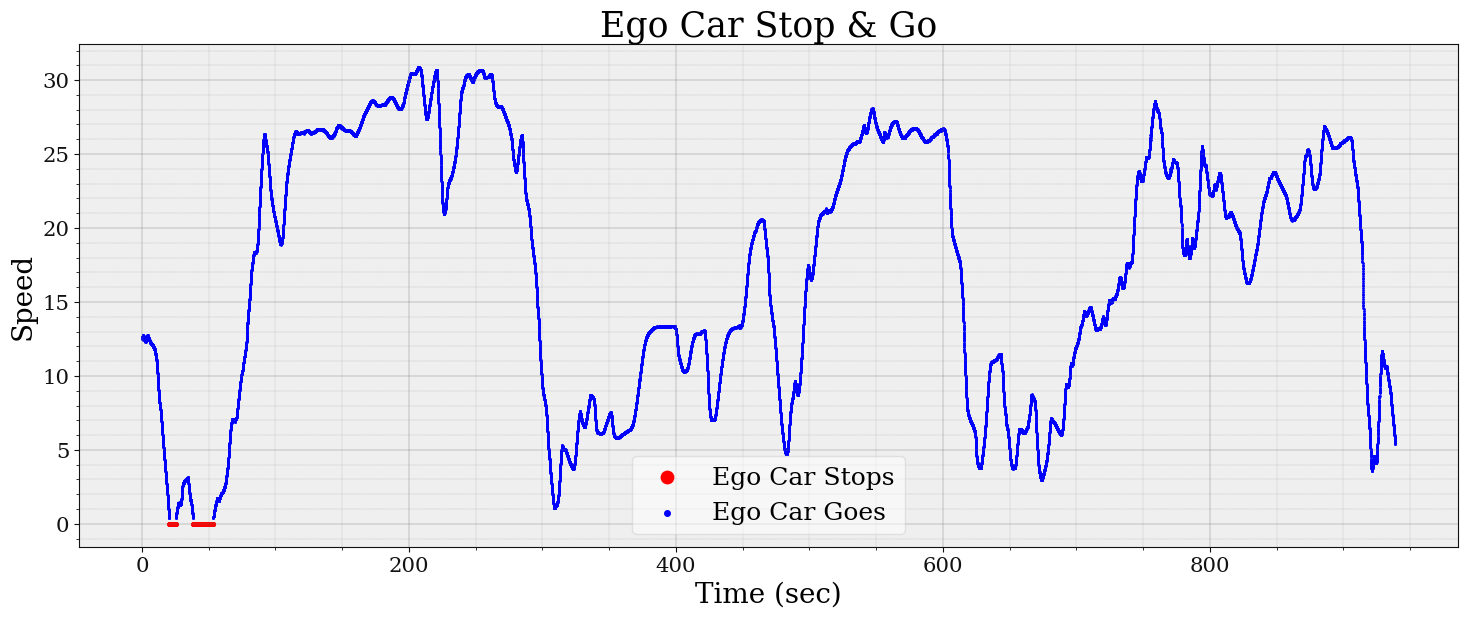

In [146]:
ts_speed['speed_mps'] = ts_speed.Message * 1000/3600
t0 = ts_speed.iloc[0].Time
fig, ax = strymread.create_fig(1)
plt.scatter(ts_speed[ts_speed.speed_mps==0].Time-t0,ts_speed[ts_speed.speed_mps==0].speed_mps,c='red',s=5,label='Ego Car Stops')
plt.scatter(ts_speed[ts_speed.speed_mps>0].Time-t0,ts_speed[ts_speed.speed_mps>0].speed_mps,c='blue',s=1,label='Ego Car Goes')
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Speed")
plt.title("Ego Car Stop & Go")
plt.show()

In [147]:
lead_distance = r.lead_distance()
lead_distance.reset_index(inplace=True)
lead_distance.head(1)

,Clock,Time,Message
0,2020-07-09 03:22:14.485035776,1.594265e+09,23


In [148]:
ts_speed.columns = ['Clock','Time','Speed','speed_mps']
lead_distance.columns = ['Clock','Time','LeadDistance']
merge_data = pd.merge_asof(ts_speed[['Clock','Time','Speed']],lead_distance[['Clock','LeadDistance']],on='Clock',allow_exact_matches=False,direction='backward')

In [149]:
merge_data = merge_data.merge(cruise_speed_merge_data[['Clock','CruiseState']],on='Clock',how='left')
merge_data.head(1)

,Clock,Time,Speed,LeadDistance,CruiseState
0,2020-07-09 03:22:14.401134848,1.594265e+09,45.16,NaN,NaN


In [150]:
keep_list = []
keep_list.append(index_list[0])
for i in range(len(index_list)-1):
    if (index_list[i+1]-index_list[i])==1:
        continue
    elif (index_list[i+1]-index_list[i])>1:
        keep_list.append(index_list[i])
        keep_list.append(index_list[i+1])
keep_list.append(index_list[-1])

In [151]:
index_list = cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].index

## Safety Analysis

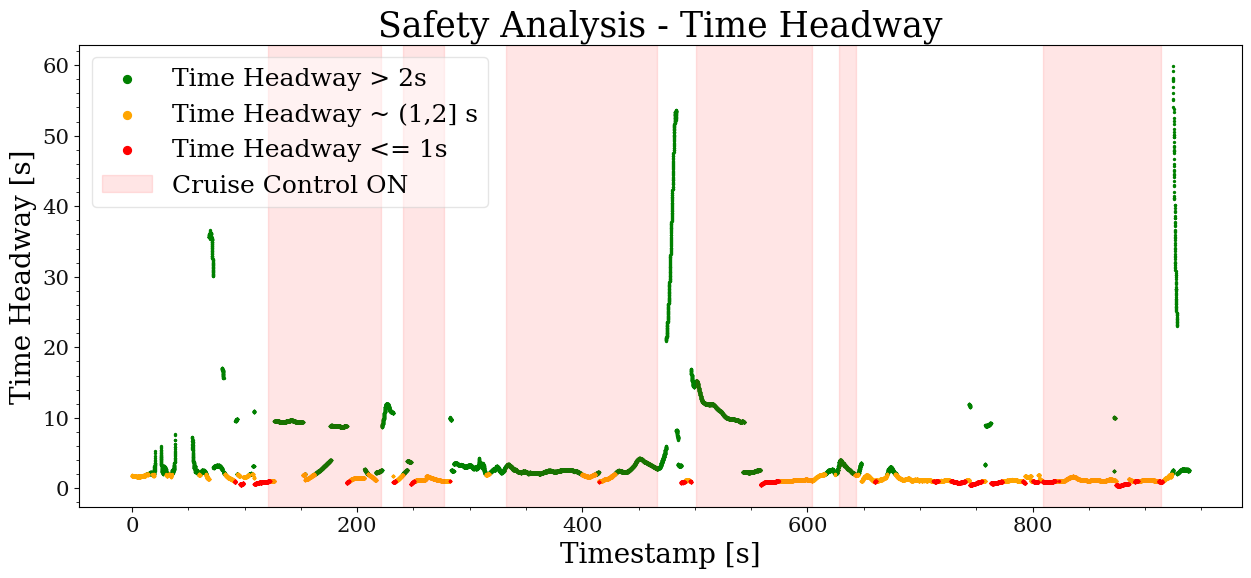

In [153]:
merge_data['speed_mps'] = merge_data.Speed * 1000/3600
merge_data['time_gap'] = merge_data.LeadDistance / merge_data.speed_mps
t0 = merge_data.iloc[0].Time
plt.scatter(merge_data[merge_data.time_gap>2].Time-t0, merge_data[merge_data.time_gap>2].time_gap,c='green',s=2,label='Time Headway > 2s')
plt.scatter(merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].Time-t0, merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].time_gap,c='orange',s=2,label='Time Headway ~ (1,2] s')
plt.scatter(merge_data[merge_data.time_gap<=1].Time-t0, merge_data[merge_data.time_gap<=1].time_gap,c='red',s=2,label='Time Headway <= 1s')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Time Headway [s]")
plt.title("Safety Analysis - Time Headway")
plt.show()

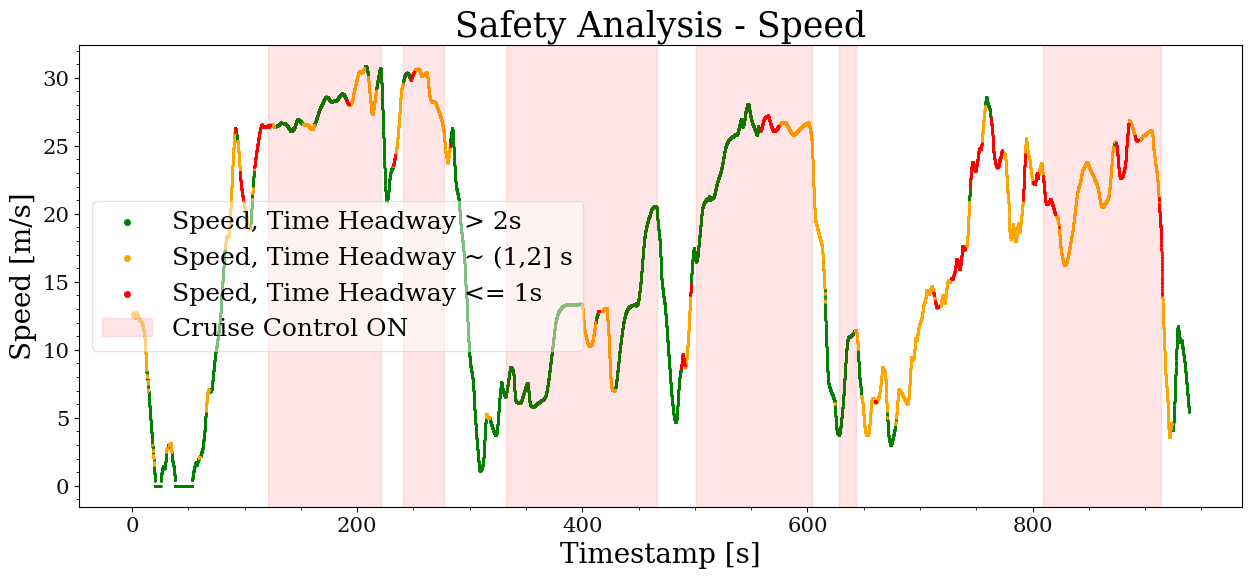

In [154]:
merge_data['speed_mps'] = merge_data.Speed * 1000/3600
merge_data['time_gap'] = merge_data.LeadDistance / merge_data.speed_mps
t0 = merge_data.iloc[0].Time
plt.scatter(merge_data[merge_data.time_gap>2].Time-t0, merge_data[merge_data.time_gap>2].speed_mps,c='green',s=1,label='Speed, Time Headway > 2s')
plt.scatter(merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].Time-t0, merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].speed_mps,c='orange',s=1,label='Speed, Time Headway ~ (1,2] s')
plt.scatter(merge_data[merge_data.time_gap<=1].Time-t0, merge_data[merge_data.time_gap<=1].speed_mps,c='red',s=1,label='Speed, Time Headway <= 1s')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Speed [m/s]")
plt.title("Safety Analysis - Speed")
plt.show()

In [155]:
print("normal area percentage:",round(merge_data[merge_data.time_gap>2].shape[0]/merge_data.shape[0]*100,1),"%.",merge_data[merge_data.time_gap>2].shape[0],";",merge_data.shape[0])
print("attention area percentage:",round(merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0]/merge_data.shape[0]*100,1),"%.",merge_data[(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0])
print("alert area percentage:",round(merge_data[merge_data.time_gap<=1].shape[0]/merge_data.shape[0]*100,1),"%.",merge_data[merge_data.time_gap<=1].shape[0])
print("safety index:",100-round(merge_data[merge_data.time_gap<=1].shape[0]/merge_data.shape[0]*100,1))

normal area percentage: 47.4 %. 17145 ; 36172
attention area percentage: 40.2 %. 14544
alert area percentage: 12.4 %. 4479
safety index: 87.6


In [156]:
# cruise control on
print("normal area percentage:",round(merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap>2)].shape[0]/merge_data[merge_data.CruiseState==1].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap>2)].shape[0],";",merge_data[merge_data.CruiseState==1].shape[0])
print("attention area percentage:",round(merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0]/merge_data[merge_data.CruiseState==1].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0])
print("alert area percentage:",round(merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap<=1)].shape[0]/merge_data[merge_data.CruiseState==1].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap<=1)].shape[0])
print("safety index:",100-round(merge_data[(merge_data.CruiseState==1)&(merge_data.time_gap<=1)].shape[0]/merge_data[merge_data.CruiseState==1].shape[0]*100,1))

normal area percentage: 50.7 %. 9644 ; 19034
attention area percentage: 39.6 %. 7534
alert area percentage: 9.8 %. 1856
safety index: 90.2


In [157]:
# cruise control on
print("normal area percentage:",round(merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap>2)].shape[0]/merge_data[merge_data.CruiseState==0].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap>2)].shape[0],";",merge_data[merge_data.CruiseState==0].shape[0])
print("attention area percentage:",round(merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0]/merge_data[merge_data.CruiseState==0].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap>1)&(merge_data.time_gap<=2)].shape[0])
print("alert area percentage:",round(merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap<=1)].shape[0]/merge_data[merge_data.CruiseState==0].shape[0]*100,1),"%.",merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap<=1)].shape[0])
print("safety index:",100-round(merge_data[(merge_data.CruiseState==0)&(merge_data.time_gap<=1)].shape[0]/merge_data[merge_data.CruiseState==0].shape[0]*100,1))

normal area percentage: 43.8 %. 7501 ; 17136
attention area percentage: 40.9 %. 7010
alert area percentage: 15.3 %. 2623
safety index: 84.7


## Comfort Evaluation

In [158]:
steering_angle = r.steer_angle()

In [159]:
steering_angle.reset_index(drop=False,inplace=True)
steering_angle.columns = ['Clock','Time','Message']

In [160]:
steering_angle_c = steering_angle.copy()
steering_angle_c.index += 1
steering_angle_c = steering_angle_c[['Time','Message']]
steering_angle_c.columns = ['Time_prev','Message_prev']
steering_angle_concat = pd.concat([steering_angle,steering_angle_c],axis=1)
steering_angle_concat.dropna(inplace=True)
steering_angle_concat.head(1)

,Clock,Time,Message,Time_prev,Message_prev
1,2020-07-09 03:22:14.413180160,1.594265e+09,0.0,1.594265e+09,0.0


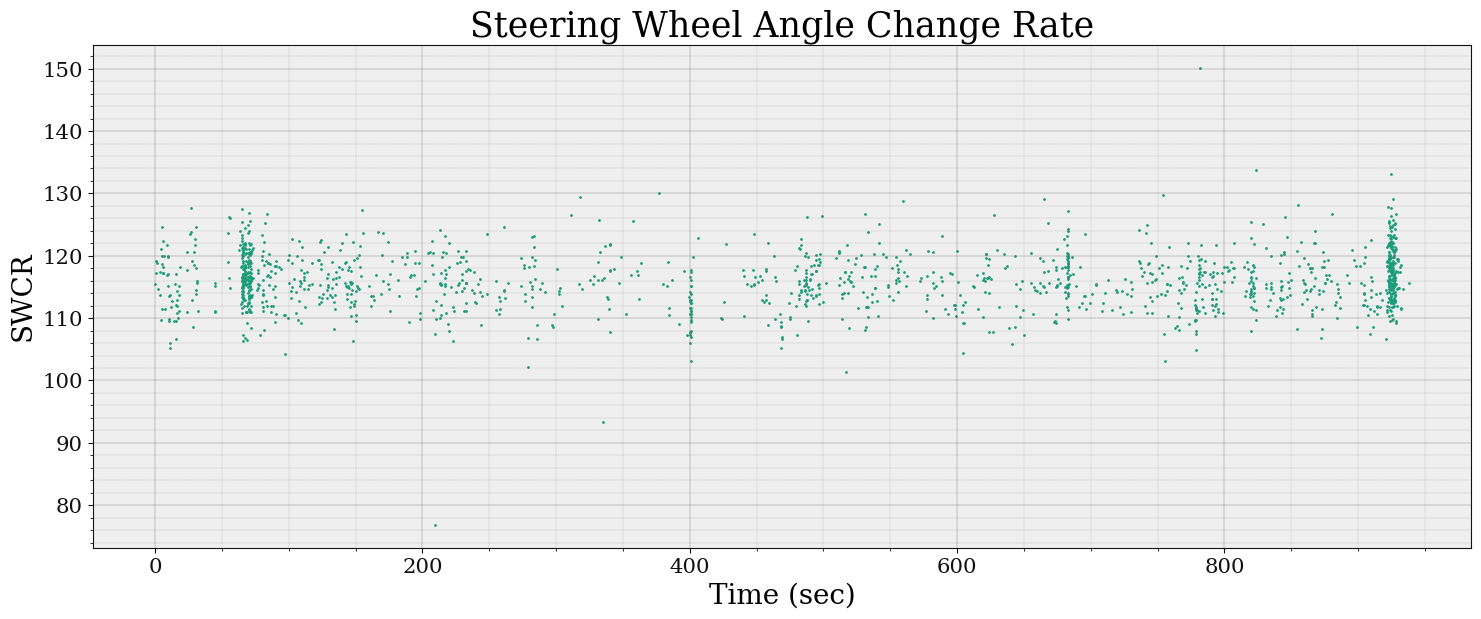

In [161]:
#steering wheel angle change rate (SWCR)
steering_angle_concat['swcr'] = (steering_angle_concat.Message-steering_angle_concat.Message_prev)/(steering_angle_concat.Time-steering_angle_concat.Time_prev)
t0 = steering_angle_concat.iloc[1].Time
fig, ax = strymread.create_fig(1)
plt.scatter(steering_angle_concat[steering_angle_concat.swcr!=0].Time-t0,abs(steering_angle_concat[steering_angle_concat.swcr!=0].swcr),s=1)
plt.xlabel("Time (sec)")
plt.ylabel("SWCR")
plt.title("Steering Wheel Angle Change Rate")
plt.show()

In [162]:
ts_speed_c = ts_speed.copy()
ts_speed_c.index += 1
ts_speed_c = ts_speed_c[['Time','speed_mps']]
ts_speed_c.columns = ['Time_prev','speed_mps_prev']
ts_speed_concat = pd.concat([ts_speed,ts_speed_c],axis=1)
ts_speed_concat.dropna(inplace=True)
ts_speed_concat.head(1)

,Clock,Time,Speed,speed_mps,Time_prev,speed_mps_prev
1,2020-07-09 03:22:14.426441984,1.594265e+09,45.36,12.6,1.594265e+09,12.544444


In [163]:
ts_speed_concat['accel_by_speed'] = (ts_speed_concat.speed_mps-ts_speed_concat.speed_mps_prev)/(ts_speed_concat.Time-ts_speed_concat.Time_prev)

In [164]:
accelx = r.accelx()

In [165]:
accelx.reset_index(drop=False,inplace=True)
accelx.columns = ['Clock','Time','Message']

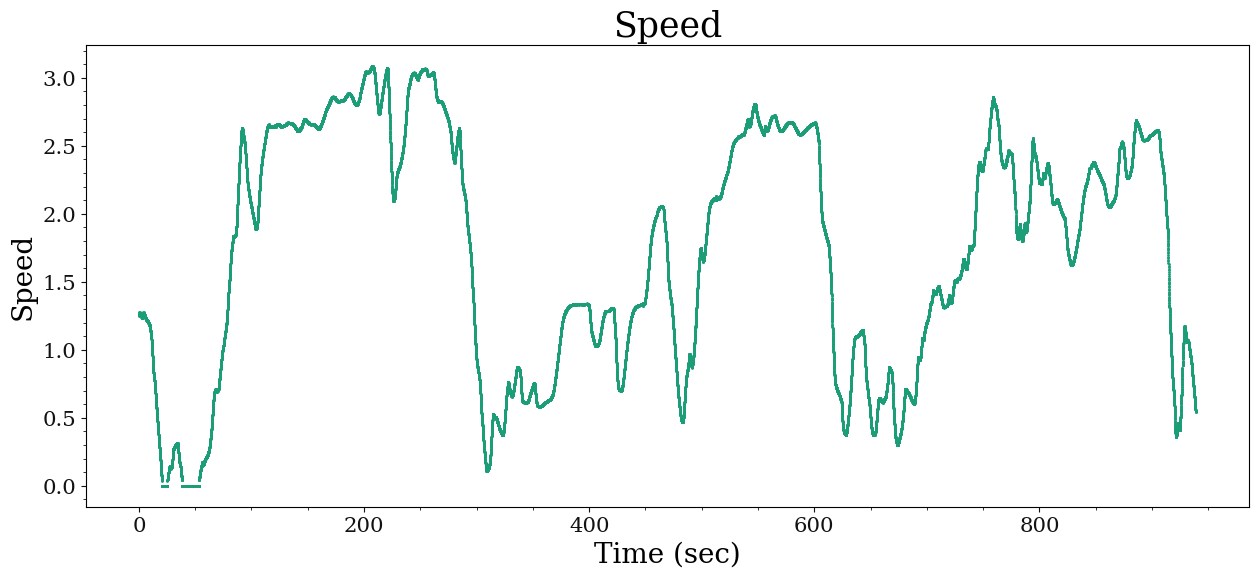

In [166]:
plt.scatter(ts_speed.Time-t0,ts_speed.speed_mps/10,s=1)
plt.xlabel("Time (sec)")
plt.ylabel("Speed")
plt.title("Speed")
plt.show()

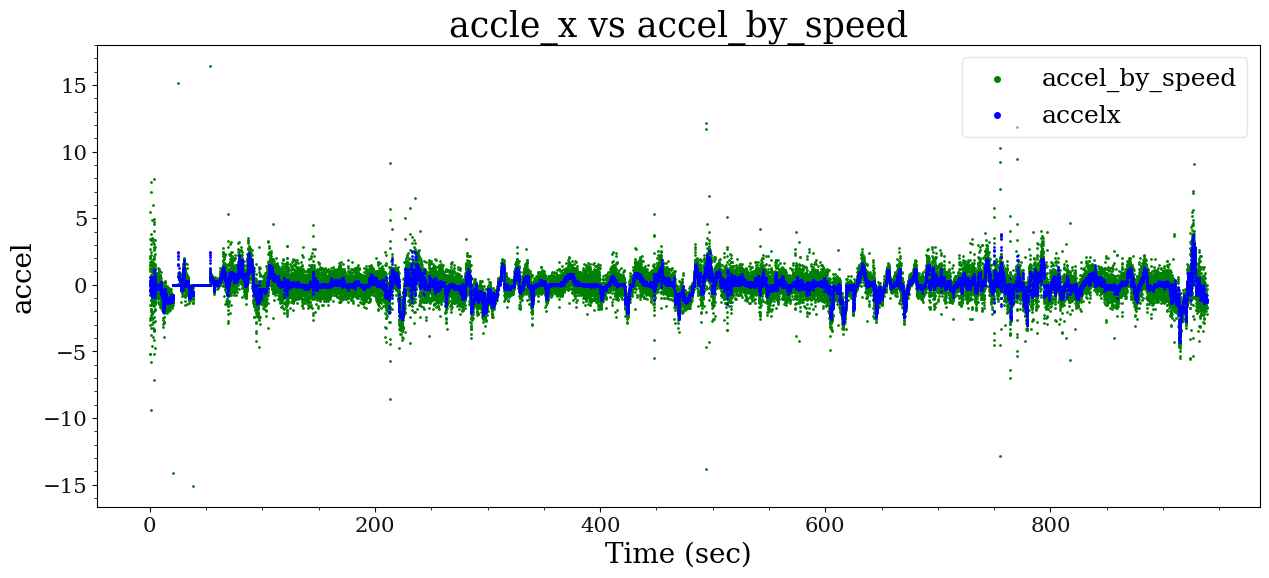

In [167]:
plt.scatter(ts_speed_concat.Time-t0,ts_speed_concat.accel_by_speed,s=1,label='accel_by_speed',c='g')
plt.scatter(accelx.Time-t0,accelx.Message,s=1,label='accelx',c='b')
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("accel")
plt.title("accle_x vs accel_by_speed")
plt.show()

In [168]:
accelx_c = accelx.copy()
accelx_c.index += 1
accelx_c = accelx_c[['Time','Message']]
accelx_c.columns = ['Time_prev','Message_prev']
accelx_concat = pd.concat([accelx,accelx_c],axis=1)
accelx_concat.dropna(inplace=True)
accelx_concat.head(1)

,Clock,Time,Message,Time_prev,Message_prev
1,2020-07-09 03:22:14.447858176,1.594265e+09,0.095,1.594265e+09,-0.295


In [169]:
accelx_concat['jerk'] = (accelx_concat.Message-accelx_concat.Message_prev)/(accelx_concat.Time-accelx_concat.Time_prev)

In [170]:
cruise = cruise_speed_merge_data[1:-1]

In [171]:
speed = ts_speed[1:-1]

In [172]:
jerk_ana = pd.concat([accelx_concat,speed[['speed_mps']],cruise[['CruiseState']]],axis=1)

In [173]:
jerk_ana = jerk_ana[['Clock','Time','speed_mps','Message','jerk','CruiseState']]
jerk_ana.columns = ['Clock','Time','speed','accel','jerk','CruiseState']
jerk_ana.head(1)

,Clock,Time,speed,accel,jerk,CruiseState
1,2020-07-09 03:22:14.447858176,1.594265e+09,12.6,0.095,14.750298,NaN


In [174]:
property_ = (jerk_ana.accel>2)|(jerk_ana.accel<-3.5)|(jerk_ana.jerk>5)|(jerk_ana.jerk<-5)

In [175]:
jerk_ana[-property_].shape[0]/jerk_ana.shape[0],jerk_ana[-property_].shape[0],jerk_ana.shape[0]

(0.8912358307990047, 32236, 36170)

In [176]:
jerk_ana[(-property_)& (jerk_ana.CruiseState==1)].shape[0]/jerk_ana[jerk_ana.CruiseState==1].shape[0],jerk_ana[(-property_)& (jerk_ana.CruiseState==1)].shape[0],jerk_ana[jerk_ana.CruiseState==1].shape[0]

(0.9021750551644426, 17172, 19034)

In [177]:
jerk_ana[(-property_)& (jerk_ana.CruiseState==0)].shape[0]/jerk_ana[jerk_ana.CruiseState==0].shape[0],jerk_ana[(-property_)& (jerk_ana.CruiseState==0)].shape[0],jerk_ana[jerk_ana.CruiseState==0].shape[0]

(0.8791362707907792, 15064, 17135)

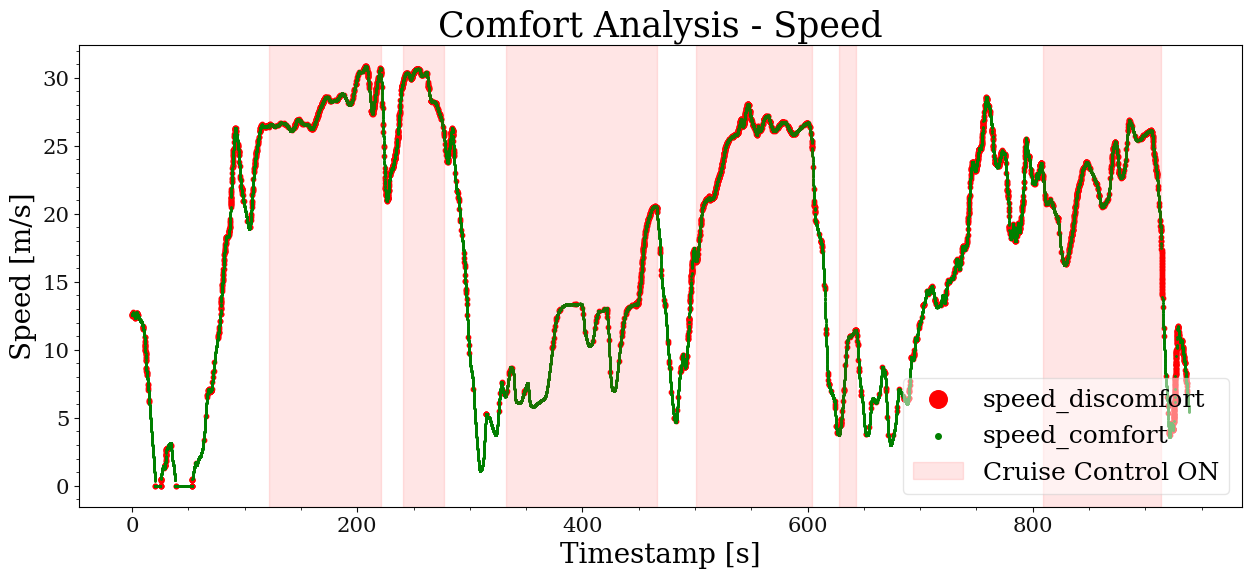

In [178]:
t0 = jerk_ana.Time[1]
plt.scatter(jerk_ana[property_].Time-t0,jerk_ana[property_].speed,s=10,label='speed_discomfort',color='red')
plt.scatter(jerk_ana[-property_].Time-t0,jerk_ana[-property_].speed,s=1,label='speed_comfort',color='green')
#plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].accel),s=1,label='acceleration_discomfort',color='red')
#plt.scatter(jerk_ana[-property_].Time-t0,abs(jerk_ana[-property_].accel),s=1,label='acceleration_comfort',color='green')
#plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].jerk/10),s=1,label='jerk_discomfort',color='pink')
#plt.scatter(jerk_ana[jerk_ana.CruiseState==1].Time-t0,jerk_ana[jerk_ana.CruiseState==1].CruiseState*2,c='blue',s=2,label='cruise control on')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Speed [m/s]")
plt.title("Comfort Analysis - Speed")
plt.show()

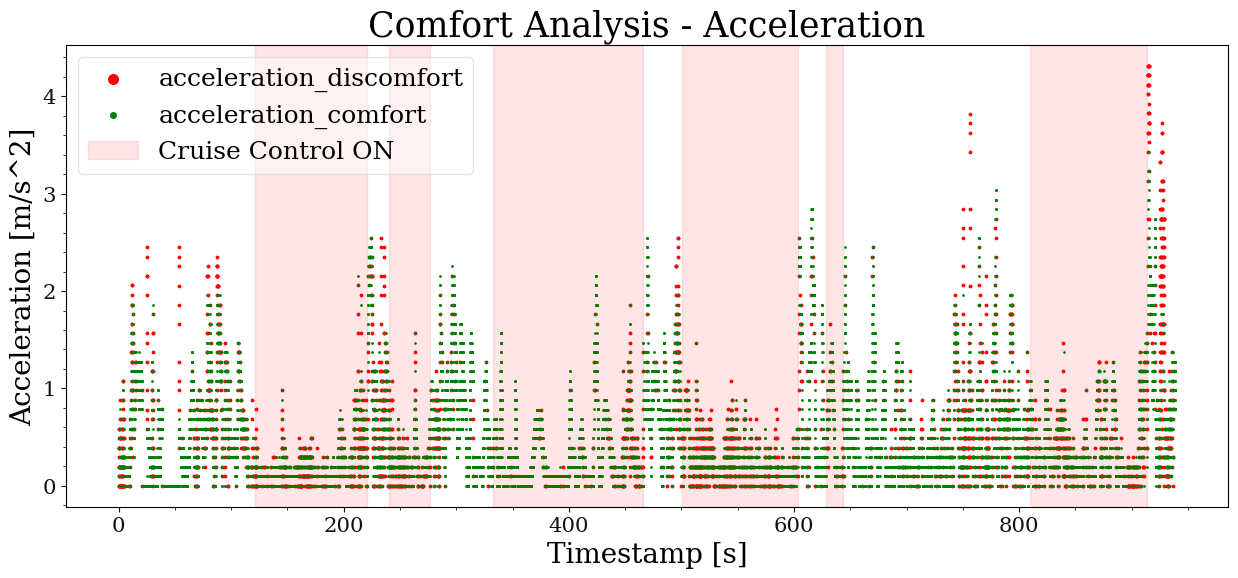

In [179]:
t0 = jerk_ana.Time[1]
#plt.scatter(jerk_ana[property_].Time-t0,jerk_ana[property_].speed/10,s=1,label='speed_discomfort',color='red')
#plt.scatter(jerk_ana[-property_].Time-t0,jerk_ana[-property_].speed/10,s=1,label='speed_comfort',color='green')
plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].accel),s=3,label='acceleration_discomfort',color='red')
plt.scatter(jerk_ana[-property_].Time-t0,abs(jerk_ana[-property_].accel),s=1,label='acceleration_comfort',color='green')
#plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].jerk/10),s=1,label='jerk_discomfort',color='pink')
#plt.scatter(jerk_ana[jerk_ana.CruiseState==1].Time-t0,jerk_ana[jerk_ana.CruiseState==1].CruiseState*2,c='blue',s=1,label='cruise control on')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Comfort Analysis - Acceleration")
plt.show()

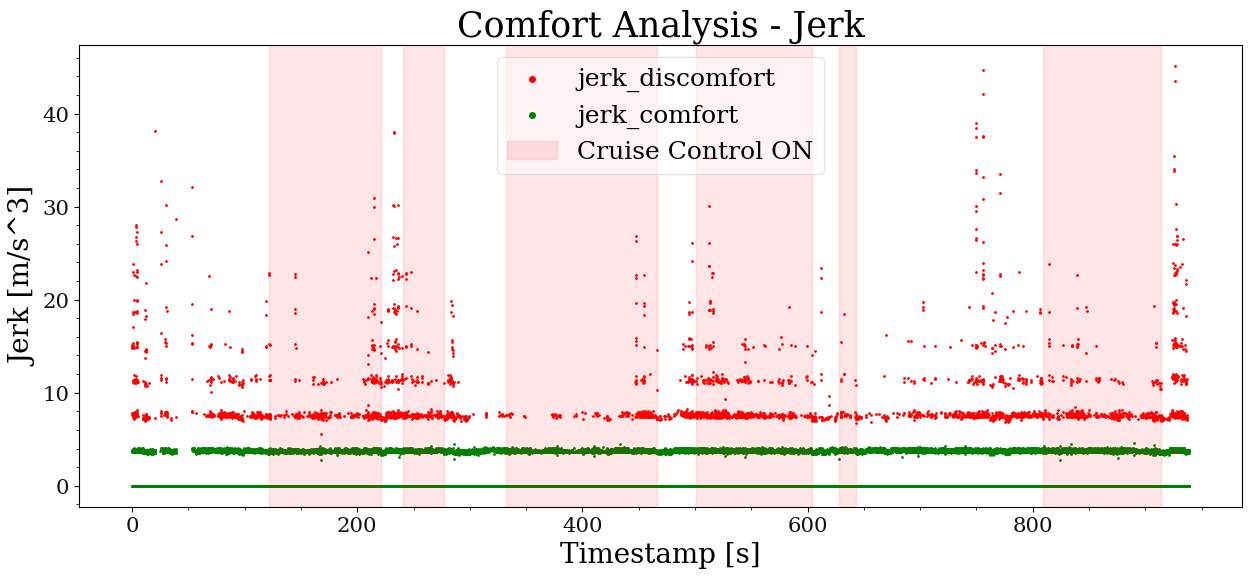

In [180]:
t0 = jerk_ana.Time[1]
#plt.scatter(jerk_ana[property_].Time-t0,jerk_ana[property_].speed/10,s=1,label='speed_discomfort',color='red')
#plt.scatter(jerk_ana[-property_].Time-t0,jerk_ana[-property_].speed/10,s=1,label='speed_comfort',color='green')
#plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].accel),s=1,label='acceleration_discomfort',color='red')
#plt.scatter(jerk_ana[-property_].Time-t0,abs(jerk_ana[-property_].accel),s=1,label='acceleration_comfort',color='green')
plt.scatter(jerk_ana[property_].Time-t0,abs(jerk_ana[property_].jerk),s=1,label='jerk_discomfort',color='red')
plt.scatter(jerk_ana[-property_].Time-t0,abs(jerk_ana[-property_].jerk),s=1,label='jerk_comfort',color='green')
#plt.scatter(jerk_ana[jerk_ana.CruiseState==1].Time-t0,jerk_ana[jerk_ana.CruiseState==1].CruiseState*2,c='blue',s=1,label='cruise control on')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Jerk [m/s^3]")
plt.title("Comfort Analysis - Jerk")
plt.show()

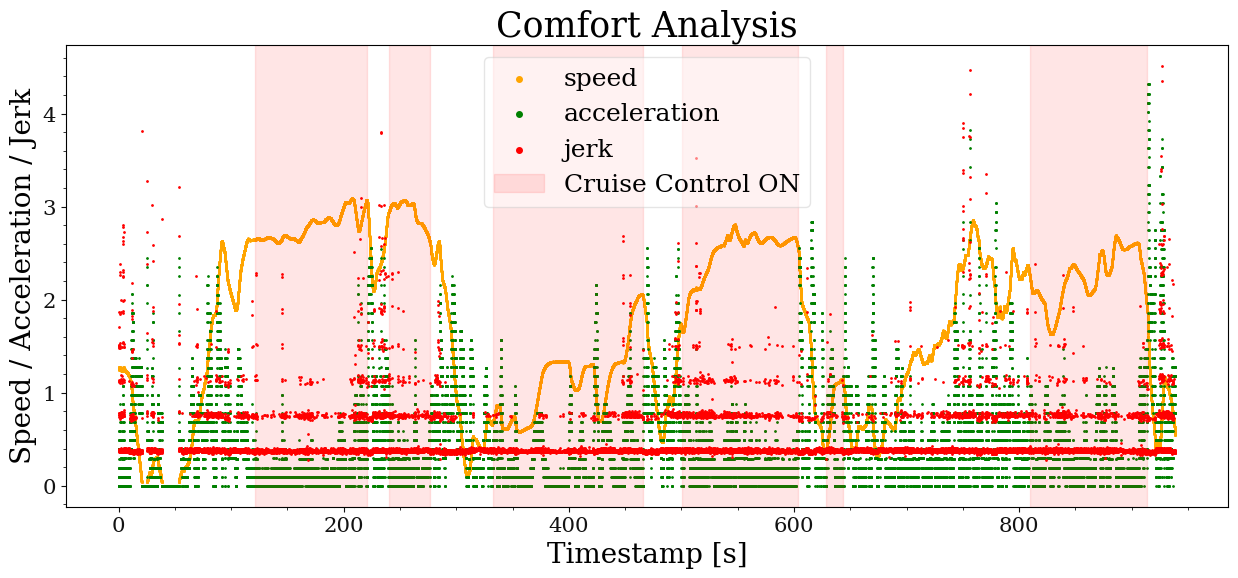

In [181]:
t0 = jerk_ana.Time[1]
plt.scatter(jerk_ana.Time-t0,jerk_ana.speed/10,s=1,label='speed',color='orange')
plt.scatter(jerk_ana.Time-t0,abs(jerk_ana.accel),s=1,label='acceleration',color='green')
plt.scatter(jerk_ana[jerk_ana.jerk!=0].Time-t0,abs(jerk_ana[jerk_ana.jerk!=0].jerk/10),s=1,label='jerk',color='red')
#plt.scatter(jerk_ana[jerk_ana.CruiseState==1].Time-t0,jerk_ana[jerk_ana.CruiseState==1].CruiseState*2,c='blue',s=1,label='cruise control on')
for i in range(int(len(keep_list)/2-1)):
    plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[i*2+1]]-t0,color='red',alpha=0.1)
plt.axvspan(cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2]]-t0,cruise_speed_merge_data[cruise_speed_merge_data.CruiseState==1].Time[keep_list[int(len(keep_list)/2-1)*2+1]]-t0,color='red',alpha=0.1, label='Cruise Control ON')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Speed / Acceleration / Jerk")
plt.title("Comfort Analysis")
plt.show()

In [184]:
# Root Mean Square (RMS) of acceleration
import math
math.sqrt(pow(accelx.Message,2).sum())

123.85215682417486

In [187]:
merge_acc_cruise = pd.merge_asof(accelx[['Clock','Time','Message']],cruise_state[['Time','CruiseState']],on='Time',allow_exact_matches=False,direction='backward')

In [188]:
# Root Mean Square (RMS) of acceleration when cruise cotrol on 
math.sqrt(pow(merge_acc_cruise[merge_acc_cruise.CruiseState==1].Message,2).sum())

53.98001898851093

In [189]:
# Root Mean Square (RMS) of acceleration when cruise cotrol off
math.sqrt(pow(merge_acc_cruise[merge_acc_cruise.CruiseState==0].Message,2).sum())

111.4694006218747

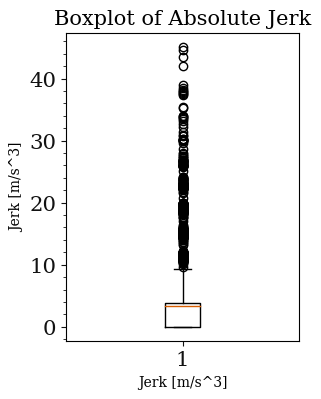

In [190]:
plt.figure(figsize = (3,4))
plt.boxplot(abs(jerk_ana.jerk))
plt.xlabel("Jerk [m/s^3]",fontsize=10)
plt.ylabel("Jerk [m/s^3]",fontsize=10)
plt.title("Boxplot of Absolute Jerk",fontsize=15)
plt.show()

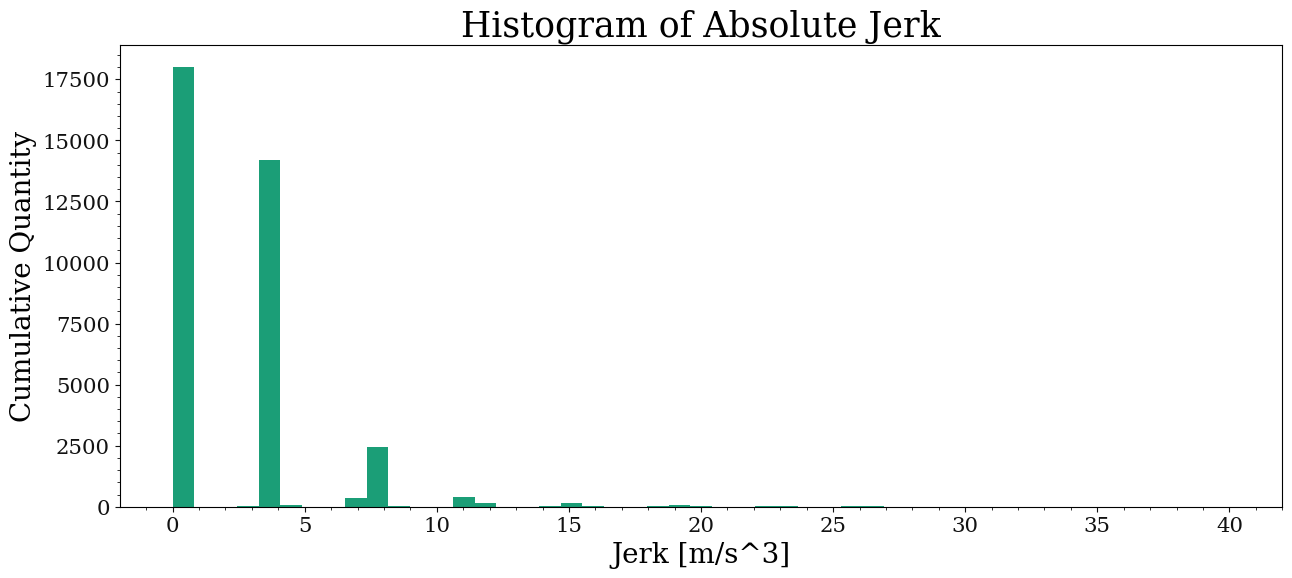

In [191]:
# Specify custom bins
custom_bins = np.linspace(0, 40, 50)  # Example: 50 bins from 0 to 4

plt.hist(abs(jerk_ana.jerk),bins=custom_bins)
plt.xlabel("Jerk [m/s^3]")
plt.ylabel("Cumulative Quantity")
plt.title("Histogram of Absolute Jerk")
plt.show()

## Fuel Efficiency

In [ ]:
root_folder = 'data/'
dbc_folder = 'dbc/'
dbcfile = root_folder+dbc_folder+'toyota_rav4_2019.dbc'
folders = ["1", "2", "3", "4", "5", "6"]
files = [
        ["2020-07-08-20-22-14_Toyota_CAN_Messages.csv"],
        ["2020-10-13-14-24-44_Toyota_CAN_Messages.csv"],
        ["2021-02-03-21-47-14_Toyota2_CAN_Messages.csv"],
        ["2021-02-11-06-29-10_Toyota2_CAN_Messages.csv", "2021-02-11-12-26-23_Toyota2_CAN_Messages.csv", "2021-02-11-12-58-30_Toyota2_CAN_Messages.csv", "2021-02-11-16-31-56_Toyota2_CAN_Messages.csv"],
        ["2021-04-06-09-22-30_Toyota2_CAN_Messages.csv", "2021-04-06-10-23-29_Toyota2_CAN_Messages.csv", "2021-04-06-11-13-20_Toyota2_CAN_Messages.csv", "2021-04-06-11-16-05_Toyota2_CAN_Messages.csv"],
        ["2021-04-16-14-07-16_Toyota2_CAN_Messages.csv", "2021-04-16-14-11-06_Toyota2_CAN_Messages.csv"]
    ]

In [ ]:
def plot_data_with_cruise_state(ts_data, cruise_state, y_label, title):
    # Merge the ts_data and cruise control state data based on the closest time stamps
    merged_data = pd.merge_asof(ts_data[['Time', 'InstantaneousEfficiency']], cruise_state[['Time', 'Message']], on='Time', allow_exact_matches=False, direction='nearest')
    
    merged_data.rename(columns={'Message': 'CruiseState'}, inplace=True)
    # Subtract the initial time to start the plot from zero
    t0 = merged_data.iloc[0].Time
    merged_data['Time'] -= t0
    
    # Create the plot
    #plt.figure(figsize=(10, 6))
    fig, ax = strymread.create_fig(1)
    plt.scatter(merged_data[merged_data.CruiseState == 1].Time, merged_data[merged_data.CruiseState == 1].InstantaneousEfficiency, c='blue', s=1, label='Cruise Control ON')
    plt.scatter(merged_data[merged_data.CruiseState == 0].Time, merged_data[merged_data.CruiseState == 0].InstantaneousEfficiency, c='grey', s=1, label='Cruise Control OFF')
    
    plt.xlabel('Timestamp [s]')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

def calculate_instantaneous_efficiency(speedDF):
    a = 5.0  # L/100km when idling
    b = 0.05  # L/100km per kph
    c = 0.001  # L/100km per kph^2
    d = 0.2  # L/100km per m/s^2

    # Ensure the DataFrame is sorted by time and drop duplicates
    speedDF = speedDF.sort_values(by='Time').drop_duplicates(subset='Time', keep='first').copy()

    # Calculate acceleration
    speedDF['Acceleration'] = speedDF['Message'].diff() / speedDF['Time'].diff()
    speedDF['Acceleration'].fillna(0, inplace=True)

    # Calculate fuel consumption rate (L/100km)
    speedDF['FuelConsumptionRate'] = a + b * speedDF['Message'] + c * speedDF['Message']**2 + d * speedDF['Acceleration']

    # Prepare for odometer calculation
    speed_c = speedDF[['Time', 'Message', 'FuelConsumptionRate']].copy()
    speed_c['Time_prev'] = speed_c['Time'].shift(-1)
    speed_c['Speed_prev'] = speed_c['Message'].shift(-1)
    speed_c.dropna(inplace=True)

    # Calculate odometer readings
    speed_c['odometer'] = (speed_c['Message'] + speed_c['Speed_prev']) * (speed_c['Time_prev'] - speed_c['Time']) / 3600 / 2

    # Convert fuel consumption rate to actual fuel consumed in each interval (in L)
    speed_c['FuelConsumed'] = speed_c['FuelConsumptionRate'] * speed_c['odometer'] / 100

    if (speed_c['FuelConsumed'] == 0).any():
        print("Warning: Zero fuel consumption values detected.")

    # Calculate instantaneous fuel efficiency (km/L)
    speed_c['InstantaneousEfficiency'] = speed_c['odometer'] / speed_c['FuelConsumed']
    speed_c['InstantaneousEfficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)

    if speed_c['InstantaneousEfficiency'].isna().any():
        print("Warning: NaN values detected in InstantaneousEfficiency.")
        speed_c['InstantaneousEfficiency'].fillna(0, inplace=True)

    # Set negative values to 0
    speed_c['InstantaneousEfficiency'] = speed_c['InstantaneousEfficiency'].clip(lower=0)

    return speed_c


def scale_efficiency(efficiency, max_value=15.0, min_value=5.0):
    efficiency = max(min(efficiency, max_value), min_value)
    scaled_efficiency = (efficiency - min_value) / (max_value - min_value)
    return scaled_efficiency

def process_file(csvdata, dbcfile):
    db = cantools.database.Database()
    with open(dbcfile,'r') as fin:    
        db = cantools.database.load(fin)
    drive = pd.read_csv(csvdata)
    r = strymread(csvfile=csvdata, dbcfile=dbcfile, createdb=True, verbose=False)
    ts_speed = r.speed()
    ts_speed.reset_index(inplace=True)
    
    cruise_state = s.convertData('PCM_CRUISE', 'CRUISE_ACTIVE', drive, db)
    
    cruise_on = ts_speed[ts_speed['Time'].isin(cruise_state[cruise_state['Message'] == 1]['Time'])]
    cruise_off = ts_speed[ts_speed['Time'].isin(cruise_state[cruise_state['Message'] == 0]['Time'])]

    ts_speed = calculate_instantaneous_efficiency(ts_speed)
    cruise_on = calculate_instantaneous_efficiency(cruise_on)
    cruise_off = calculate_instantaneous_efficiency(cruise_off)
    
    
    overall_efficiency = ts_speed['InstantaneousEfficiency'].mean()
    cruise_on_efficiency = cruise_on['InstantaneousEfficiency'].mean()
    cruise_off_efficiency = cruise_off['InstantaneousEfficiency'].mean()
    
    # Return the drive and db along with other data
    return overall_efficiency, cruise_on_efficiency, cruise_off_efficiency, ts_speed, cruise_on, cruise_off, drive, db

In [ ]:
csvdata = 'data/1/2020-07-08-20-22-14_Toyota_CAN_Messages.csv'
overall_efficiency, cruise_on_efficiency, cruise_off_efficiency, ts_speed, cruise_on, cruise_off, drive, db = process_file(csvdata, dbcfile)
cruise_state = s.convertData('PCM_CRUISE', 'CRUISE_ACTIVE', drive, db)

In [ ]:
plot_data_with_cruise_state(ts_speed, cruise_state, 'Fuel Efficiency [km/L]', f'Fuel Efficiency with Cruise Control State ON/OFF')

In [ ]:
for folder, file_list in zip(folders, files):
        for file in file_list:
            csvdata = os.path.join(root_folder+folder, file)
            # Capture the returned drive and db here
            overall_efficiency, cruise_on_efficiency, cruise_off_efficiency, ts_speed, cruise_on, cruise_off, drive, db = process_file(csvdata, dbcfile)
            
            # Pass the drive and db to the convertData function
            cruise_state = s.convertData('PCM_CRUISE', 'CRUISE_ACTIVE', drive, db)
            plot_data_with_cruise_state(ts_speed, cruise_state, 'Fuel Efficiency (km/L)', f'Fuel Efficiency with Cruise Control State for {file}')
            
            
            overall_percentage = scale_efficiency(overall_efficiency) * 100
            cruise_on_percentage = scale_efficiency(cruise_on_efficiency) * 100
            cruise_off_percentage = scale_efficiency(cruise_off_efficiency) * 100

            print(f"Fuel Efficiency for {file}:")
            print(f"Overall: {overall_efficiency:.2f} km/L ({overall_percentage:.2f}%)")
            print(f"Cruise Control ON: {cruise_on_efficiency:.2f} km/L ({cruise_on_percentage:.2f}%)")
            print(f"Cruise Control OFF: {cruise_off_efficiency:.2f} km/L ({cruise_off_percentage:.2f}%)")
            print("-------------------------------")